<a href="https://colab.research.google.com/github/Edd1enator/Tesis_Prediccion_Sequias/blob/main/Copia_de_ModeloKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio geopandas tensorflow scikit-image tqdm matplotlib -q
!apt install gdal-bin python3-gdal -qqq

!apt-get update -y
!apt-get install -y git build-essential cmake libssl-dev
!pip install lightgbm

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow import keras
import lightgbm as lgb
import joblib
from numpy import random
from sklearn.ensemble import RandomForestClassifier
import warnings

np.set_printoptions(linewidth=130)

warnings.filterwarnings('ignore')

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Configurando GPUs...")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No se detectaron GPUs, usando CPU")

Configurando GPUs...


In [ ]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU detectada: {len(gpus)} dispositivos")
            print("Configuración de GPU optimizada")
        except RuntimeError as e:
            print(f"Error configurando GPU: {e}")
    else:
        print("No se detectó GPU")

    print(f"Versión de TensorFlow: {tf.__version__}")

except ImportError:
    print("Error en la configuración de aceleración")

GPU detectada: 1 dispositivos
Configuración de GPU optimizada
Versión de TensorFlow: 2.19.0


In [ ]:
base_path = "/content/drive/MyDrive/Tesis/DataKaggle"

train_path = os.path.join(base_path, "train_timeseries")
test_path = os.path.join(base_path, "test_timeseries")
validation_path = os.path.join(base_path, "validation_timeseries")
soil_data_path = os.path.join(base_path, "soil_data.csv")

OUTPUT_DIR = "/content/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
batch_size = 1024
epochs = 50
random_state = 38
k_folds = 2
LEARNING_RATE = 3e-4

In [ ]:
mae_scores = []
r2_scores = []
models = []

In [ ]:
#@title Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Función de carga de datos
def carga_data(folder_path):
    all_files = []

    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                df = pd.read_csv(file_path)
                df['source_file'] = file
                all_files.append(df)

        if all_files:
            return pd.concat(all_files, ignore_index=True)
        else:
            print(f"No se encontraron archivos CSV en {folder_path}")
            return pd.DataFrame()
    else:
        print(f"La carpeta {folder_path} no existe")
        return pd.DataFrame()

In [ ]:
# Carga de datos para entorno
print("Cargando datos de entrenamiento...")
train_data = carga_data(train_path)

print("Cargando datos de prueba...")
test_data = carga_data(test_path)

print("Cargando datos de validación...")
validation_data = carga_data(validation_path)

print("Cargando datos del suelo...")
soil_data = pd.read_csv(soil_data_path) if os.path.exists(soil_data_path) else pd.DataFrame()

Cargando datos de entrenamiento...
Cargando datos de prueba...
Cargando datos de validación...
Cargando datos del suelo...


In [ ]:
# Limpieza de datos nulos en fips y date
train_data = train_data.dropna(subset=['fips', 'date'])
test_data = test_data.dropna(subset=['fips', 'date'])
validation_data = validation_data.dropna(subset=['fips', 'date'])

In [ ]:
print("=== ESTRUCTURA DE LOS DATOS ===")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Soil data shape: {soil_data.shape}")

if not train_data.empty:
    print("\nColumnas en train_data:")
    print(train_data.columns.tolist())
    print("\nPrimeras filas de train_data:")
    print(train_data.head())

=== ESTRUCTURA DE LOS DATOS ===
Train data shape: (19300680, 22)
Test data shape: (2271948, 22)
Validation data shape: (2268840, 22)
Soil data shape: (3109, 32)

Columnas en train_data:
['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'score', 'source_file']

Primeras filas de train_data:
   fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score           source_file
0  1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96    11.46       9.50  14.65   2.20       2.94       1.49         1.46   4.85       6.04       3.23         2.81    NaN  train_timeseries.csv
1  1001  2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80    12.61      10.18  16.60   2.52       3

In [ ]:
def visualizar_dataset(df, name):

    if df.empty:
        print(f"{name}: Dataset vacío")
        return

    print(f"\n=== ANÁLISIS DE {name.upper()} ===")
    print(f"Dimensiones: {df.shape}")
    print(f"Columnas: {df.columns.tolist()}")
    print(f"Tipos de datos:")
    print(df.dtypes)
    print(f"Valores nulos:")
    print(df.isnull().sum())

In [ ]:
visualizar_dataset(train_data, "train_data")
visualizar_dataset(soil_data, "soil_data")


=== ANÁLISIS DE TRAIN_DATA ===
Dimensiones: (19300680, 22)
Columnas: ['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'score', 'source_file']
Tipos de datos:
fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
source_file     object
dtype: object
Valores nulos:
fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T

In [ ]:
def buscar_columna_objetivo(df):
    """Busca columnas relacionadas con sequía"""
    drought_keywords = ['drought', 'sequia', 'dry', 'aridity', 'water_stress', 'index']
    target_cols = []

    for col in df.columns:
        col_lower = col.lower()
        for keyword in drought_keywords:
            if keyword in col_lower:
                target_cols.append(col)
                break
    return target_cols

In [ ]:
target_columns = buscar_columna_objetivo(train_data)
print("Columnas objetivo potenciales:", target_columns)

if not target_columns and not train_data.empty:
    numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
    print("Columnas numéricas disponibles:", numeric_cols)
    if numeric_cols:
        target_columns = [numeric_cols[-1]]
        print(f"Usando '{target_columns[0]}' como columna objetivo por defecto")

Columnas objetivo potenciales: []
Columnas numéricas disponibles: ['fips', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'score']
Usando 'score' como columna objetivo por defecto


In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

print("Configuración actualizada - Ahora puedes ver más registros")

train_data.score.head(100)

Configuración actualizada - Ahora puedes ver más registros


,score
0,NaN
1,NaN
2,NaN
3,1.0000
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [ ]:
date_col = None
for c in ['date','fecha','timestamp','time']:
    if c in train_data.columns:
        date_col = c
        break
if date_col is None:
    raise ValueError("No encontré columna de fecha; asigna date_col manualmente.")

target_col = None
for c in train_data.columns:
    if 'score' in c.lower():
        target_col = c
        break
if target_col is None:
    raise ValueError("No encontré columna objetivo que contenga 'score' en su nombre.")

# normalizar fecha y ordenar
train_data[date_col] = pd.to_datetime(train_data[date_col], errors='coerce').dt.normalize()
train_data = train_data.dropna(subset=[date_col])
train_data = train_data.sort_values([ 'fips', date_col ]).reset_index(drop=True)

print("Datos cargados:", train_data.shape)
print("date_col:", date_col, "target_col:", target_col)

Datos cargados: (19300680, 22)
date_col: date target_col: score


In [ ]:
# weekly_list = []
# grouped = train_data.groupby('fips')

# for fid, g in grouped:
#     g = g.copy()
#     g[date_col] = pd.to_datetime(g[date_col], errors='coerce').dt.normalize()
#     g = g.set_index(date_col).sort_index()

#     numeric_cols = g.select_dtypes(include=[np.number]).columns.tolist()
#     numeric_cols = [c for c in numeric_cols if c != target_col]

#     # construir series diarias promedio
#     daily = g[numeric_cols].resample('D').mean()

#     # agregar semanalmente con etiqueta el martes
#     weekly = daily.resample('W-TUE').mean()

#     score_s = g[[target_col]].dropna().groupby(level=0).first()

#     wk = weekly.join(score_s, how='left')

#     wk = wk.reset_index().rename(columns={'index': date_col})
#     wk['fips'] = fid
#     weekly_list.append(wk)

# weekly_df = pd.concat(weekly_list, ignore_index=True)
# weekly_df = weekly_df.rename(columns={date_col: 'date'})

# print("weekly_df shape:", weekly_df.shape)
# print(weekly_df[[ 'fips', 'date', target_col ]].head(10))


In [ ]:
def transform_to_weekly(data, target_col='score'):
    if data.empty:
        return pd.DataFrame()

    weekly_list = []
    grouped = data.groupby('fips')

    for fid, g in grouped:
        g = g.copy()
        g['date'] = pd.to_datetime(g['date'], errors='coerce').dt.normalize()
        g = g.set_index('date').sort_index()

        numeric_cols = g.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [c for c in numeric_cols if c != target_col]

        daily = g[numeric_cols].resample('D').mean()
        weekly = daily.resample('W-TUE').mean()

        if target_col in g.columns:
            score_s = g[[target_col]].dropna().groupby(level=0).first()
            weekly = weekly.join(score_s, how='left')

        weekly = weekly.reset_index().rename(columns={'index': 'date'})
        weekly['fips'] = fid
        weekly_list.append(weekly)

    result = pd.concat(weekly_list, ignore_index=True)
    print(f"  Transformación semanal: {data.shape[0]} → {result.shape[0]} filas")
    return result

In [ ]:
# Carga de datos
print("Cargando datos de entrenamiento")
train_data = carga_data(train_path)
test_data = carga_data(test_path)
validation_data = carga_data(validation_path)

# Limpieza básica
for df in [train_data, test_data, validation_data]:
    df.dropna(subset=['fips', 'date'], inplace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.normalize()

Cargando datos de entrenamiento


In [ ]:
# # Transformaciones semanal
# print("\nTransformando a datos semanales:")
# weekly_train = transform_to_weekly(train_data, target_col='score')
# weekly_test = transform_to_weekly(test_data, target_col='score')
# weekly_val = transform_to_weekly(validation_data, target_col='score')

# print(f"\nShapes finales:")
# print(f"  Train:  {weekly_train.shape}")
# print(f"  Test:   {weekly_test.shape}")
# print(f"  Val:    {weekly_val.shape}")

In [ ]:
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', None)

# print("Configuración actualizada - Ahora puedes ver más registros")

# weekly_train.score.tail(100)

In [ ]:
def create_features_production_safe(df, target_col='score', max_target_lag=2):

    df = df.copy()
    df = df.sort_values(['fips', 'date']).reset_index(drop=True)

    climate_vars = ['PRECTOT', 'T2M', 'QV2M', 'PS', 'WS10M', 'TS']
    climate_vars = [v for v in climate_vars if v in df.columns]

    # 1. Lags del target
    # Se inicia con lag2 asumiendo 1 semana de retraso
    for lag in [2, 3, 4, 6, 8]:
        df[f'target_lag{lag}'] = df.groupby('fips')[target_col].shift(lag)

    # Media móvil de target
    df['target_ma4'] = df.groupby('fips')[target_col].transform(
        lambda x: x.shift(2).rolling(4, min_periods=1).mean()
    )
    df['target_ma8'] = df.groupby('fips')[target_col].transform(
        lambda x: x.shift(2).rolling(8, min_periods=1).mean()
    )

    # 2. Features climáticas
    for var in climate_vars:
        for lag in [1, 2, 4, 8]:
            df[f'{var}_lag{lag}'] = df.groupby('fips')[var].shift(lag)

        for window in [2, 4, 8]:
            df[f'{var}_ma{window}'] = df.groupby('fips')[var].transform(
                lambda x: x.rolling(window, min_periods=1).mean()
            )

        fips_mean = df.groupby('fips')[var].transform('mean')
        fips_std = df.groupby('fips')[var].transform('std').replace(0, 1)
        df[f'{var}_anomaly'] = (df[var] - fips_mean) / fips_std

    # 3. Features de precipitación
    if 'PRECTOT' in df.columns:
        # Acumulados
        for w in [2, 4, 8]:
            df[f'PRECTOT_sum{w}'] = df.groupby('fips')['PRECTOT'].transform(
                lambda x: x.rolling(w, min_periods=1).sum()
            )

        # Déficit de precipitación vs promedio histórico
        precip_mean = df.groupby('fips')['PRECTOT'].transform('mean')
        df['PRECTOT_deficit'] = precip_mean - df['PRECTOT']
        df['PRECTOT_deficit_ma4'] = df.groupby('fips')['PRECTOT_deficit'].transform(
            lambda x: x.rolling(4, min_periods=1).mean()
        )

    # 4. Índices de sequía simples
    if 'PRECTOT' in df.columns and 'T2M' in df.columns:
        # Índice de aridez
        df['aridity'] = df['T2M'] / (df['PRECTOT'] + 0.1)
        df['aridity_ma4'] = df.groupby('fips')['aridity'].transform(
            lambda x: x.rolling(4, min_periods=1).mean()
        )

    if 'T2M' in df.columns and 'QV2M' in df.columns:
        # Demanda evaporativa aproximada
        df['evap_demand'] = df['T2M'] / (df['QV2M'] + 0.01)

    # 5. Features temporales
    if 'date' in df.columns:
        df['month'] = df['date'].dt.month
        df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
        df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

    return df

In [ ]:
# print("Creando features production-safe")
# weekly_train_v2 = create_features_production_safe(weekly_train.copy(), 'score')
# weekly_test_v2 = create_features_production_safe(weekly_test.copy(), 'score')
# weekly_val_v2 = create_features_production_safe(weekly_val.copy(), 'score')

In [ ]:
def preprocess_final(df, target_col='score'):
    """
    Preprocesamiento final (SIN crear features, solo limpieza)
    """
    if df.empty:
        return None, None

    df = df.copy()

    # Eliminar columnas no numéricas
    cols_to_drop = ['date', 'source_file']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Eliminar filas sin target
    df = df.dropna(subset=[target_col])

    # Separar X e y
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Imputar NaN
    for col in X.select_dtypes(include=[np.number]).columns:
        if X[col].isnull().any():
            X[col].fillna(X[col].median(), inplace=True)

    print(f"  Preprocesado: X={X.shape}, y={y.shape}, y_range=[{y.min():.2f}, {y.max():.2f}]")

    return X, y

In [ ]:
# 1. Transformar a semanal
print("Paso 1: Transformando a semanal...")
weekly_train = transform_to_weekly(train_data, 'score')
weekly_test = transform_to_weekly(test_data, 'score')
weekly_val = transform_to_weekly(validation_data, 'score')

# 2. Crear features production-safe
print("\nPaso 2: Creando features...")
weekly_train = create_features_production_safe(weekly_train, 'score')
weekly_test = create_features_production_safe(weekly_test, 'score')
weekly_val = create_features_production_safe(weekly_val, 'score')

# 3. Preprocesar
print("\nPaso 3: Preprocesando...")
X_train, y_train = preprocess_final(weekly_train, 'score')
X_test, y_test = preprocess_final(weekly_test, 'score')
X_val, y_val = preprocess_final(weekly_val, 'score')

# 4. Alinear columnas
common_cols = sorted(set(X_train.columns) & set(X_test.columns) & set(X_val.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]
X_val = X_val[common_cols]

print(f"\nFeatures finales: {len(common_cols)}")
print(f"¿target_lag2 incluido?: {'target_lag2' in common_cols}")

Paso 1: Transformando a semanal...
  Transformación semanal: 19300680 → 2759904 filas
  Transformación semanal: 2271948 → 329448 filas
  Transformación semanal: 2268840 → 326340 filas

Paso 2: Creando features...

Paso 3: Preprocesando...
  Preprocesado: X=(2756796, 86), y=(2756796,), y_range=[0.00, 5.00]
  Preprocesado: X=(326340, 86), y=(326340,), y_range=[0.00, 5.00]
  Preprocesado: X=(323232, 86), y=(323232,), y_range=[0.00, 5.00]

Features finales: 86
¿target_lag2 incluido?: True


In [ ]:
# Preprocesar
# X_train, y_train = preprocess_final(weekly_train, 'score')
# X_test, y_test = preprocess_final(weekly_test, 'score')
# X_val, y_val = preprocess_final(weekly_val, 'score')

# # Alinear columnas
# common_cols = sorted(set(X_train.columns) & set(X_test.columns) & set(X_val.columns))
# X_train = X_train[common_cols]
# X_test = X_test[common_cols]
# X_val = X_val[common_cols]

In [ ]:
# def simple_oversample(X, y, threshold_low=1.0, threshold_high=4.0, factor=2):
#     """
#     Sobremuestrea casos con valores extremos del target
#     """
#     df = pd.concat([X, y], axis=1)
#     target_col = y.name

#     # Identificar casos extremos
#     extreme_mask = (y < threshold_low) | (y > threshold_high)
#     extreme_cases = df[extreme_mask]
#     normal_cases = df[~extreme_mask]

#     print(f"Casos normales: {len(normal_cases)}")
#     print(f"Casos extremos: {len(extreme_cases)}")

#     # Duplicar casos extremos
#     oversampled = pd.concat([
#         normal_cases,
#         *[extreme_cases] * factor  # Duplicar 'factor' veces
#     ], ignore_index=True)

#     # Separar X e y
#     X_resampled = oversampled.drop(columns=[target_col])
#     y_resampled = oversampled[target_col]

#     print(f"Total después de sobremuestreo: {len(y_resampled)}")

#     return X_resampled, y_resampled

# # Verificar distribución primero
# print("Distribución del target:")
# print(y_train.describe())
# print("\nConteo por bins:")
# print(pd.cut(y_train, bins=5).value_counts().sort_index())

# # Aplicar sobremuestreo
# print("\nAplicando sobremuestreo...")
# X_train_balanced, y_train_balanced = simple_oversample(
#     X_train,
#     y_train,
#     threshold_low=1.0,   # Ajusta según tu distribución
#     threshold_high=4.0,  # Ajusta según tu distribución
#     factor=3             # Cuántas veces duplicar casos extremos
# )

In [ ]:
def balanced_oversample_v2(X, y):

    df = pd.concat([X, y.rename('score')], axis=1)

    bins_config = [
        {'range': (0, 1), 'factor': 1},
        {'range': (1, 2), 'factor': 2},
        {'range': (2, 3), 'factor': 3},
        {'range': (3, 4), 'factor': 4},
        {'range': (4, 5), 'factor': 5},
    ]

    resampled_parts = []

    print("Rebalanceando datos (conservador):")
    print("-" * 50)

    for config in bins_config:
        low, high = config['range']
        factor = config['factor']

        mask = (df['score'] >= low) & (df['score'] < high)
        subset = df[mask]

        for _ in range(factor):
            resampled_parts.append(subset.copy())

        print(f"  [{low}-{high}): {len(subset):>7} x {factor} = {len(subset)*factor:>8}")

    result = pd.concat(resampled_parts, ignore_index=True).sample(frac=1, random_state=42)

    X_res = result.drop(columns=['score'])
    y_res = result['score']

    print("-" * 50)
    print(f"  Total: {len(y):,} → {len(y_res):,}")

    return X_res, y_res

In [ ]:
X_train_bal, y_train_bal = balanced_oversample_v2(X_train, y_train)

Rebalanceando datos (conservador):
--------------------------------------------------
  [0-1): 1794623 x 1 =  1794623
  [1-2):  424353 x 2 =   848706
  [2-3):  265995 x 3 =   797985
  [3-4):  169049 x 4 =   676196
  [4-5):   80970 x 5 =   404850
--------------------------------------------------
  Total: 2,756,796 → 4,522,360


In [ ]:
# print(pd.Series(y_train).value_counts(normalize=True) * 100)

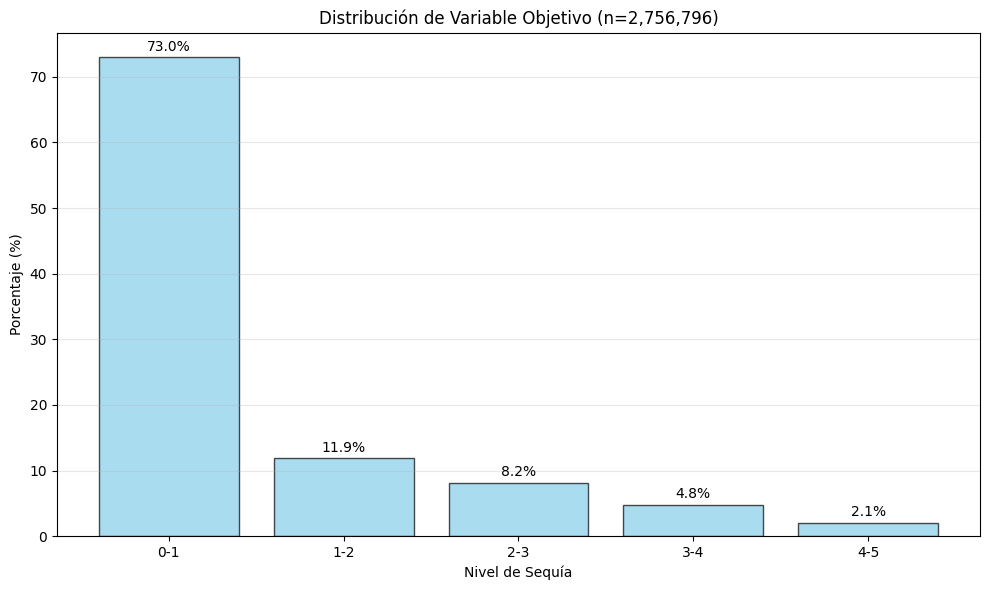

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

# Agrupar en rangos discretos (bins)
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']

y_binned = pd.cut(y_train, bins=bins, labels=labels, include_lowest=True)
percentages = y_binned.value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(percentages.index, percentages.values, color='skyblue', edgecolor='black', alpha=0.7)

for bar, percentage in zip(bars, percentages.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Nivel de Sequía')
plt.ylabel('Porcentaje (%)')
plt.title(f'Distribución de Variable Objetivo (n={len(y_train):,})')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

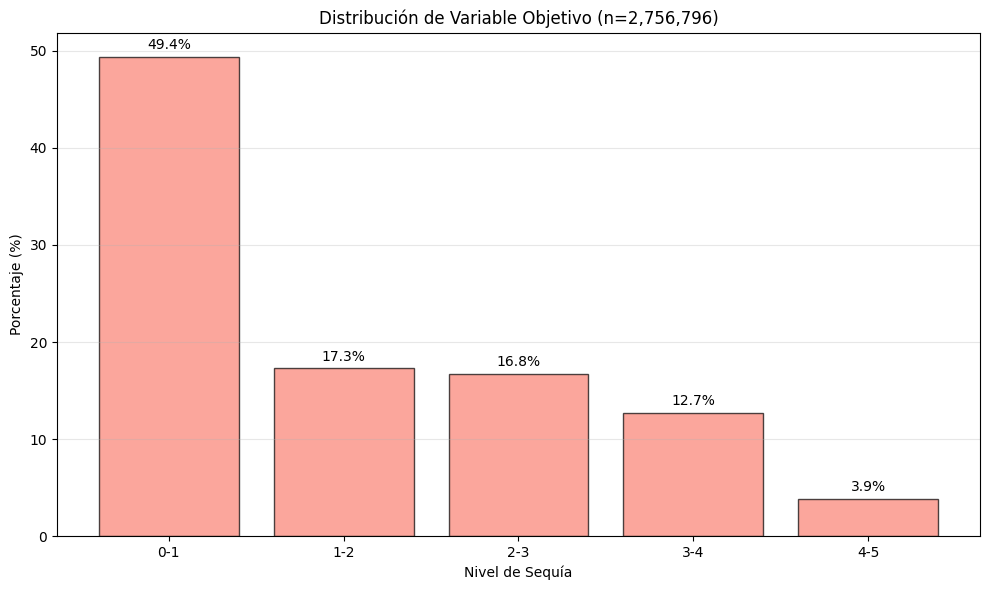

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

# Agrupar en rangos discretos (bins)
bins = [0, 1, 2, 3, 4, 5]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']

y_binned = pd.cut(y_train_bal, bins=bins, labels=labels, include_lowest=True)
percentages = y_binned.value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(percentages.index, percentages.values, color='salmon', edgecolor='black', alpha=0.7)

for bar, percentage in zip(bars, percentages.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Nivel de Sequía')
plt.ylabel('Porcentaje (%)')
plt.title(f'Distribución de Variable Objetivo (n={len(y_train):,})')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
model_balanced = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    n_estimators=1000,
    num_leaves=31,
    max_depth=8,
    min_child_samples=20,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

model_balanced.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='mae',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=50)
    ]
)

# Evaluar
pred_balanced = model_balanced.predict(X_test)

print("\n" + "=" * 50)
print("=== Modelo con datos balanceados ===")
print("=" * 50)
print(f"MAE:  {mean_absolute_error(y_test, pred_balanced):.4f}")
print(f"R²:   {r2_score(y_test, pred_balanced):.4f}")

# Error por rango (importante para ver el efecto del balanceo)
print("\nError por rango de score:")
print("-" * 40)
for i in range(5):
    mask = (y_test >= i) & (y_test < i+1)
    if mask.sum() > 0:
        mae_r = mean_absolute_error(y_test[mask], pred_balanced[mask])
        pct = mask.sum() / len(y_test) * 100
        print(f"  [{i}-{i+1}): n={mask.sum():>6} ({pct:>5.1f}%), MAE={mae_r:.4f}")

Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 0.303138
[100]	valid_0's l1: 0.206027
[150]	valid_0's l1: 0.185347
[200]	valid_0's l1: 0.181398
[250]	valid_0's l1: 0.180515
[300]	valid_0's l1: 0.180196
[350]	valid_0's l1: 0.179862
[400]	valid_0's l1: 0.179688
[450]	valid_0's l1: 0.179514
[500]	valid_0's l1: 0.179424
[550]	valid_0's l1: 0.179383
[600]	valid_0's l1: 0.179299
[650]	valid_0's l1: 0.17925
[700]	valid_0's l1: 0.179181
[750]	valid_0's l1: 0.179147
[800]	valid_0's l1: 0.179132
[850]	valid_0's l1: 0.17915
[900]	valid_0's l1: 0.179116
[950]	valid_0's l1: 0.179151
Early stopping, best iteration is:
[874]	valid_0's l1: 0.179106

=== Modelo con datos balanceados ===
MAE:  0.1563
R²:   0.8797

Error por rango de score:
----------------------------------------
  [0-1): n=266217 ( 81.6%), MAE=0.1133
  [1-2): n= 34552 ( 10.6%), MAE=0.3638
  [2-3): n= 16698 (  5.1%), MAE=0.3341
  [3-4): n=  6691 (  2.1%), MAE=0.3105
  [4-5): n=  1957 (  0.6%), MAE=0.2678

In [ ]:
def evaluate_model(model, X_test, y_test, name="Modelo"):
    """
    Evaluación completa del modelo
    """
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    print(f"\n=== {name} ===")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # Análisis por rangos de score
    print("\nError por rango de score:")
    for i in range(0, 5):
        mask = (y_test >= i) & (y_test < i+1)
        if mask.sum() > 0:
            mae_range = mean_absolute_error(y_test[mask], pred[mask])
            print(f"  [{i}-{i+1}): n={mask.sum():4d}, MAE={mae_range:.4f}")

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': X_test.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\nTop 10 features más importantes:")
        print(importance.head(10).to_string(index=False))

    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'predictions': pred}

# Evaluar
results = evaluate_model(model_balanced, X_test, y_test, "Modelo Base")


=== Modelo Base ===
MAE:  0.1563
RMSE: 0.2908
R²:   0.8797

Error por rango de score:
  [0-1): n=266217, MAE=0.1133
  [1-2): n=34552, MAE=0.3638
  [2-3): n=16698, MAE=0.3341
  [3-4): n=6691, MAE=0.3105
  [4-5): n=1957, MAE=0.2678

Top 10 features más importantes:
            feature  importance
        target_lag2        1753
PRECTOT_deficit_ma4        1432
               fips        1043
       week_of_year        1020
       PRECTOT_lag1         697
         PS_anomaly         670
         TS_anomaly         656
       PRECTOT_sum8         644
       QV2M_anomaly         532
        T2M_anomaly         520


In [ ]:
# # === REGENERAR DESDE CERO ===

# # 1. Transformar a semanal
# print("Paso 1: Transformando a semanal...")
# weekly_train = transform_to_weekly(train_data, 'score')
# weekly_test = transform_to_weekly(test_data, 'score')
# weekly_val = transform_to_weekly(validation_data, 'score')

# # 2. Crear features production-safe
# print("\nPaso 2: Creando features...")
# weekly_train = create_features_production_safe(weekly_train, 'score')
# weekly_test = create_features_production_safe(weekly_test, 'score')
# weekly_val = create_features_production_safe(weekly_val, 'score')

# # 3. Preprocesar
# print("\nPaso 3: Preprocesando...")
# X_train, y_train = preprocess_final(weekly_train, 'score')
# X_test, y_test = preprocess_final(weekly_test, 'score')
# X_val, y_val = preprocess_final(weekly_val, 'score')

# # 4. Alinear columnas
# common_cols = sorted(set(X_train.columns) & set(X_test.columns) & set(X_val.columns))
# X_train = X_train[common_cols]
# X_test = X_test[common_cols]
# X_val = X_val[common_cols]

# print(f"\nFeatures finales: {len(common_cols)}")
# print(f"¿target_lag2 incluido?: {'target_lag2' in common_cols}")

# # 5. Entrenar SIN balanceo
# print("\nPaso 4: Entrenando modelo...")
# model_final = lgb.LGBMRegressor(
#     n_estimators=2000,
#     num_leaves=31,
#     max_depth=8,
#     learning_rate=0.02,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0.05,
#     reg_lambda=0.05,
#     min_child_samples=30,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )

# model_final.fit(
#     X_train, y_train,
#     eval_set=[(X_val, y_val)],
#     eval_metric='mae',
#     callbacks=[
#         lgb.early_stopping(200, verbose=True),
#         lgb.log_evaluation(100)
#     ]
# )

# # 6. Evaluar
# pred_final = model_final.predict(X_test)

# print("\n" + "=" * 50)
# print("=== MODELO FINAL (sin balanceo) ===")
# print("=" * 50)
# print(f"MAE:  {mean_absolute_error(y_test, pred_final):.4f}")
# print(f"R²:   {r2_score(y_test, pred_final):.4f}")

# # Feature importance
# importance = pd.DataFrame({
#     'feature': common_cols,
#     'importance': model_final.feature_importances_
# }).sort_values('importance', ascending=False)

# print("\nTop 10 features:")
# print(importance.head(10).to_string(index=False))

In [ ]:
# def create_features_production_safe(df, target_col='score', max_target_lag=2):
#     """
#     Features que SÍ estarían disponibles en producción.

#     Asumimos que:
#     - Los scores se publican con 1-2 semanas de retraso
#     - Por lo tanto target_lag2, target_lag4, etc. SÍ estarían disponibles
#     - Pero target_lag1 podría NO estar disponible (lo excluimos para ser conservadores)
#     """
#     df = df.copy()
#     df = df.sort_values(['fips', 'date']).reset_index(drop=True)

#     climate_vars = ['PRECTOT', 'T2M', 'QV2M', 'PS', 'WS10M', 'TS']
#     climate_vars = [v for v in climate_vars if v in df.columns]

#     # === 1. LAGS DEL TARGET (solo los "seguros") ===
#     # Empezamos desde lag2 asumiendo 1 semana de retraso en publicación
#     for lag in [2, 3, 4, 6, 8]:
#         df[f'target_lag{lag}'] = df.groupby('fips')[target_col].shift(lag)

#     # Media móvil del target (histórico)
#     df['target_ma4'] = df.groupby('fips')[target_col].transform(
#         lambda x: x.shift(2).rolling(4, min_periods=1).mean()
#     )
#     df['target_ma8'] = df.groupby('fips')[target_col].transform(
#         lambda x: x.shift(2).rolling(8, min_periods=1).mean()
#     )

#     # === 2. FEATURES CLIMÁTICAS ===
#     for var in climate_vars:
#         # Lags cortos y largos
#         for lag in [1, 2, 4, 8]:
#             df[f'{var}_lag{lag}'] = df.groupby('fips')[var].shift(lag)

#         # Medias móviles
#         for window in [2, 4, 8]:
#             df[f'{var}_ma{window}'] = df.groupby('fips')[var].transform(
#                 lambda x: x.rolling(window, min_periods=1).mean()
#             )

#         # Anomalía
#         fips_mean = df.groupby('fips')[var].transform('mean')
#         fips_std = df.groupby('fips')[var].transform('std').replace(0, 1)
#         df[f'{var}_anomaly'] = (df[var] - fips_mean) / fips_std

#     # === 3. FEATURES DE PRECIPITACIÓN (críticas para sequía) ===
#     if 'PRECTOT' in df.columns:
#         # Acumulados
#         for w in [2, 4, 8]:
#             df[f'PRECTOT_sum{w}'] = df.groupby('fips')['PRECTOT'].transform(
#                 lambda x: x.rolling(w, min_periods=1).sum()
#             )

#         # Déficit de precipitación vs promedio histórico
#         precip_mean = df.groupby('fips')['PRECTOT'].transform('mean')
#         df['PRECTOT_deficit'] = precip_mean - df['PRECTOT']
#         df['PRECTOT_deficit_ma4'] = df.groupby('fips')['PRECTOT_deficit'].transform(
#             lambda x: x.rolling(4, min_periods=1).mean()
#         )

#     # === 4. ÍNDICES DE SEQUÍA SIMPLES ===
#     if 'PRECTOT' in df.columns and 'T2M' in df.columns:
#         # Índice de aridez
#         df['aridity'] = df['T2M'] / (df['PRECTOT'] + 0.1)
#         df['aridity_ma4'] = df.groupby('fips')['aridity'].transform(
#             lambda x: x.rolling(4, min_periods=1).mean()
#         )

#     if 'T2M' in df.columns and 'QV2M' in df.columns:
#         # Demanda evaporativa aproximada
#         df['evap_demand'] = df['T2M'] / (df['QV2M'] + 0.01)

#     # === 5. FEATURES TEMPORALES ===
#     if 'date' in df.columns:
#         df['month'] = df['date'].dt.month
#         df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
#         df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
#         df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

#     return df


# # === APLICAR ===
# print("Creando features production-safe...")
# weekly_train_v2 = create_features_production_safe(weekly_train.copy(), 'score')
# weekly_test_v2 = create_features_production_safe(weekly_test.copy(), 'score')
# weekly_val_v2 = create_features_production_safe(weekly_val.copy(), 'score')

# # Preprocesar
# def preprocess_final(df, target_col='score'):
#     df = df.copy()
#     cols_to_drop = ['date', 'source_file']
#     df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

#     df = df.dropna(subset=[target_col])
#     X = df.drop(columns=[target_col])
#     y = df[target_col]

#     # Imputar NaN
#     for col in X.select_dtypes(include=[np.number]).columns:
#         if X[col].isnull().any():
#             X[col].fillna(X[col].median(), inplace=True)

#     return X, y

# X_train_v2, y_train_v2 = preprocess_final(weekly_train_v2)
# X_test_v2, y_test_v2 = preprocess_final(weekly_test_v2)
# X_val_v2, y_val_v2 = preprocess_final(weekly_val_v2)

# # Alinear columnas
# common = sorted(set(X_train_v2.columns) & set(X_test_v2.columns) & set(X_val_v2.columns))
# X_train_v2 = X_train_v2[common]
# X_test_v2 = X_test_v2[common]
# X_val_v2 = X_val_v2[common]

# print(f"Features: {len(common)}")
# print(f"Train: {X_train_v2.shape}, Test: {X_test_v2.shape}")

# # === ENTRENAR ===
# model_v2 = lgb.LGBMRegressor(
#     n_estimators=2000,
#     num_leaves=31,
#     max_depth=8,
#     learning_rate=0.02,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0.05,
#     reg_lambda=0.05,
#     min_child_samples=30,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )

# model_v2.fit(
#     X_train_v2, y_train_v2,
#     eval_set=[(X_val_v2, y_val_v2)],
#     eval_metric='mae',
#     callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)]
# )

# # === EVALUAR ===
# pred_v2 = model_v2.predict(X_test_v2)

# print("\n" + "="*50)
# print("=== Modelo Production-Safe ===")
# print("="*50)
# print(f"MAE:  {mean_absolute_error(y_test_v2, pred_v2):.4f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test_v2, pred_v2)):.4f}")
# print(f"R²:   {r2_score(y_test_v2, pred_v2):.4f}")

# # Feature importance
# importance = pd.DataFrame({
#     'feature': common,
#     'importance': model_v2.feature_importances_
# }).sort_values('importance', ascending=False)

# print("\nTop 15 features:")
# print(importance.head(15).to_string(index=False))

# # Error por rango
# print("\nError por rango de score:")
# for i in range(5):
#     mask = (y_test_v2 >= i) & (y_test_v2 < i+1)
#     if mask.sum() > 0:
#         mae_r = mean_absolute_error(y_test_v2[mask], pred_v2[mask])
#         print(f"  [{i}-{i+1}): n={mask.sum():>6}, MAE={mae_r:.4f}")

In [ ]:
# def balanced_oversample(X, y):
#     """
#     Balancea los datos para que cada rango tenga representación similar
#     """
#     df = pd.concat([X, y.rename('score')], axis=1)

#     # Contar por rango
#     bins_config = [
#         {'range': (0, 1), 'factor': 1},
#         {'range': (1, 2), 'factor': 8},
#         {'range': (2, 3), 'factor': 16},
#         {'range': (3, 4), 'factor': 40},
#         {'range': (4, 5), 'factor': 130},
#     ]

#     resampled_parts = []

#     print("Rebalanceando datos:")
#     print("-" * 50)

#     for config in bins_config:
#         low, high = config['range']
#         factor = config['factor']

#         mask = (df['score'] >= low) & (df['score'] < high)
#         subset = df[mask]
#         original_count = len(subset)

#         # Agregar copias
#         for _ in range(factor):
#             resampled_parts.append(subset.copy())

#         final_count = original_count * factor
#         print(f"  [{low}-{high}): {original_count:>7} x {factor:>3} = {final_count:>8}")

#     result = pd.concat(resampled_parts, ignore_index=True).sample(frac=1, random_state=42)

#     X_res = result.drop(columns=['score'])
#     y_res = result['score']

#     print("-" * 50)
#     print(f"  Total: {len(y):,} → {len(y_res):,}")

#     return X_res, y_res

# # Aplicar
# X_train_bal, y_train_bal = balanced_oversample(X_train_v2, y_train_v2)

# # Verificar nueva distribución
# print("\nNueva distribución:")
# bins = [0, 1, 2, 3, 4, 5]
# labels = ['0-1', '1-2', '2-3', '3-4', '4-5']
# y_binned = pd.cut(y_train_bal, bins=bins, labels=labels, include_lowest=True)
# print(y_binned.value_counts(normalize=True).sort_index().apply(lambda x: f"{x*100:.1f}%"))

# # Entrenar modelo con datos balanceados
# model_bal = lgb.LGBMRegressor(
#     n_estimators=2000,
#     num_leaves=31,
#     max_depth=8,
#     learning_rate=0.02,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0.05,
#     reg_lambda=0.05,
#     min_child_samples=30,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )

# model_bal.fit(
#     X_train_bal, y_train_bal,
#     eval_set=[(X_val_v2, y_val_v2)],
#     eval_metric='mae',
#     callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)]
# )

# # Evaluar
# pred_bal = model_bal.predict(X_test_v2)

# print("\n" + "=" * 50)
# print("=== Modelo Balanceado ===")
# print("=" * 50)
# print(f"MAE global:  {mean_absolute_error(y_test_v2, pred_bal):.4f}")
# print(f"R² global:   {r2_score(y_test_v2, pred_bal):.4f}")

# print("\nError por rango:")
# print("-" * 50)
# for i in range(5):
#     mask = (y_test_v2 >= i) & (y_test_v2 < i+1)
#     if mask.sum() > 0:
#         mae_r = mean_absolute_error(y_test_v2[mask], pred_bal[mask])
#         pct = mask.sum() / len(y_test_v2) * 100
#         print(f"  [{i}-{i+1}): n={mask.sum():>6} ({pct:>5.1f}%), MAE={mae_r:.4f}")

# # Comparación directa
# print("\n" + "=" * 50)
# print("=== Comparación: Original vs Balanceado ===")
# print("=" * 50)
# print(f"{'Rango':<10} {'MAE Original':>15} {'MAE Balanceado':>15} {'Mejora':>10}")
# print("-" * 50)

# mae_orig_total = 0
# mae_bal_total = 0

# for i in range(5):
#     mask = (y_test_v2 >= i) & (y_test_v2 < i+1)
#     if mask.sum() > 0:
#         mae_orig = mean_absolute_error(y_test_v2[mask], pred_v2[mask])
#         mae_bal_r = mean_absolute_error(y_test_v2[mask], pred_bal[mask])
#         mejora = (mae_orig - mae_bal_r) / mae_orig * 100
#         print(f"  [{i}-{i+1})    {mae_orig:>12.4f}   {mae_bal_r:>12.4f}   {mejora:>8.1f}%")

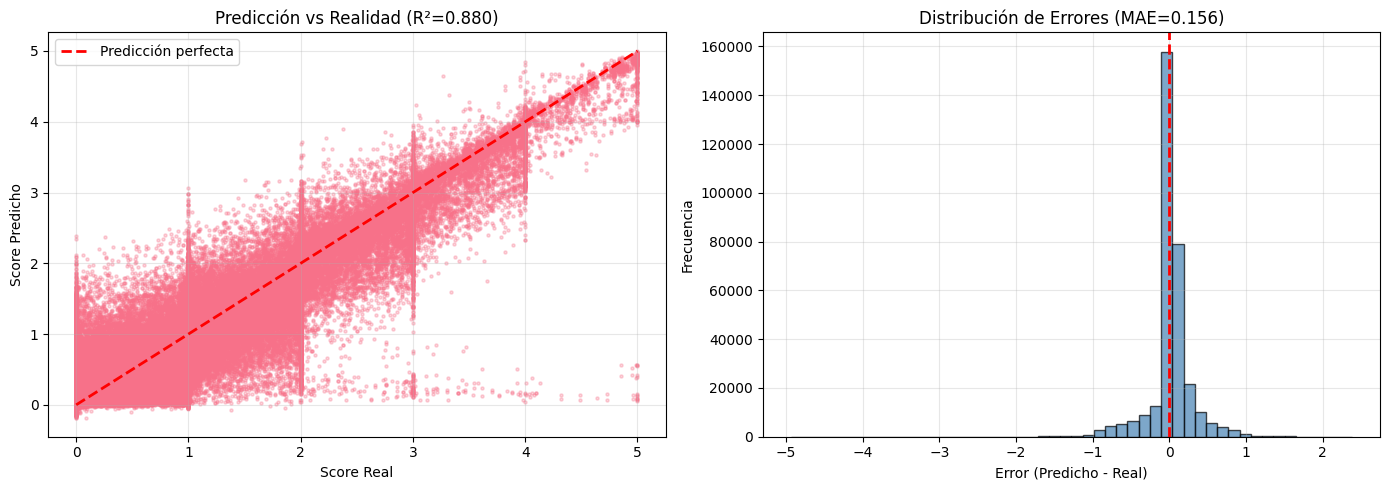

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, pred_balanced, alpha=0.3, s=5)
axes[0].plot([0, 5], [0, 5], 'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Score Real')
axes[0].set_ylabel('Score Predicho')
axes[0].set_title(f'Predicción vs Realidad (R²={r2_score(y_test, pred_balanced):.3f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribución de errores
errors = pred_balanced - y_test
axes[1].hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Error (Predicho - Real)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Errores (MAE={mean_absolute_error(y_test, pred_balanced):.3f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Error por rango con el modelo actual
print("Error actual por rango de score:")
print("-" * 40)
for i in range(5):
    mask = (y_test >= i) & (y_test < i+1)
    if mask.sum() > 0:
        mae_r = mean_absolute_error(y_test[mask], pred_balanced[mask])
        pct = mask.sum() / len(y_test) * 100
        print(f"  [{i}-{i+1}): n={mask.sum():>6} ({pct:>5.1f}%), MAE={mae_r:.4f}")

Error actual por rango de score:
----------------------------------------
  [0-1): n=266217 ( 81.6%), MAE=0.1133
  [1-2): n= 34552 ( 10.6%), MAE=0.3638
  [2-3): n= 16698 (  5.1%), MAE=0.3341
  [3-4): n=  6691 (  2.1%), MAE=0.3105
  [4-5): n=  1957 (  0.6%), MAE=0.2678


In [ ]:
drive.mount('/content/drive')

carpeta_modelo = '/content/drive/MyDrive/modelo_sequia'
os.makedirs(carpeta_modelo, exist_ok=True)

joblib.dump(model_balanced, f'{carpeta_modelo}/modelo_sequia.pkl')
joblib.dump(common_cols, f'{carpeta_modelo}/columnas_modelo.pkl')

with open(f'{carpeta_modelo}/features_list.txt', 'w') as f:
    for col in common_cols:
        f.write(col + '\n')

metadata = {
    'fecha_entrenamiento': '2025-11-25',
    'r2_score': 0.8795,
    'mae': 0.1563,
    'n_features': len(common_cols),
    'best_iteration': model_balanced.best_iteration_
}
joblib.dump(metadata, f'{carpeta_modelo}/metadata.pkl')

print("✅ Modelo guardado en Google Drive")
print(f"📁 Ubicación: {carpeta_modelo}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modelo guardado en Google Drive
📁 Ubicación: /content/drive/MyDrive/modelo_sequia


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
# def train_kfold(X, y, params, n_splits=5):
#     """Entrena modelo con k-fold y retorna métricas"""
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     mae_scores = []
#     r2_scores = []

#     for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
#         X_fold_train = X.iloc[train_idx]
#         y_fold_train = y.iloc[train_idx]
#         X_fold_val = X.iloc[val_idx]
#         y_fold_val = y.iloc[val_idx]

#         dtrain = lgb.Dataset(X_fold_train, label=y_fold_train)
#         dvalid = lgb.Dataset(X_fold_val, label=y_fold_val, reference=dtrain)

#         bst = lgb.train(
#             params,
#             dtrain,
#             num_boost_round=5000,
#             valid_sets=[dvalid],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=100),
#                 lgb.log_evaluation(period=0)
#             ]
#         )

#         y_pred = bst.predict(X_fold_val, num_iteration=bst.best_iteration)
#         mae = mean_absolute_error(y_fold_val, y_pred)
#         r2 = r2_score(y_fold_val, y_pred)

#         mae_scores.append(mae)
#         r2_scores.append(r2)

#         print(f"Fold {fold}: MAE={mae:.4f}, R²={r2:.4f}")

#     return {
#         'mae_mean': np.mean(mae_scores),
#         'mae_std': np.std(mae_scores),
#         'r2_mean': np.mean(r2_scores),
#         'r2_std': np.std(r2_scores)
#     }

In [ ]:
# rf_fast = RandomForestRegressor(
#     n_estimators=100,
#     min_samples_leaf=5,
#     max_features='sqrt',
#     n_jobs=-1,
#     random_state=42
# )

# rf_fast.fit(X_train, y_train)

In [ ]:
# importance_df = pd.DataFrame({
#     'cols': X_train.columns,
#     'imp': rf_fast.feature_importances_
# }).sort_values('imp', ascending=False)

# plt.figure(figsize=(10, 8))
# importance_df.plot('cols', 'imp', 'barh', legend=False)
# plt.title('Importancia de características con objetivo- Random Forest')
# plt.xlabel('Importancia')
# plt.tight_layout()
# plt.show()

In [ ]:
#######################################################################Puede servir############################################################

In [ ]:
# def drop(df, cols):
#     return df.drop(columns=cols_to_drop, errors='ignore')

In [ ]:
# X_train = drop(X_train, ['WS10M_MIN', 'WS50M_MIN', 'T2M', 'WS50M', 'WS50M_RANGE'])

In [ ]:
##############################################################################################################################################

In [ ]:
# def predict_ensemble(models, X):

#     preds = []
#     for m in models:

#         if isinstance(m, str):
#             booster = lgb.Booster(model_file=m)
#             it = getattr(booster, "best_iteration", None)
#             preds.append(booster.predict(X, num_iteration=it) if it else booster.predict(X))
#             continue

#         # Booster nativo
#         if isinstance(m, lgb.basic.Booster):
#             it = getattr(m, "best_iteration", None)
#             preds.append(m.predict(X, num_iteration=it) if it else m.predict(X))
#             continue

#         if isinstance(m, lgb.sklearn.LGBMRegressor):
#             it = getattr(m, "best_iteration_", None)
#             try:
#                 preds.append(m.predict(X, num_iteration=it) if it is not None else m.predict(X))
#             except TypeError:
#                 preds.append(m.predict(X))
#             continue

#         if hasattr(m, "predict"):
#             preds.append(m.predict(X))

#         else:
#             raise TypeError(f"Tipo de modelo no soportado: {type(m)}")

#     preds = np.vstack([p.ravel() for p in preds])
#     return preds.mean(axis=0)


In [ ]:

# ensemble_pred = predict_ensemble(models_full, X_test)
# print("\nMétricas ensemble en test:")
# print("  MAE:", mean_absolute_error(y_test, ensemble_pred))
# print("  R2: ", r2_score(y_test, ensemble_pred))

In [ ]:
# models_to_use = final_models if 'final_models' in globals() else models_full
# X_test_to_use = X_test_final if 'X_test_final' in globals() else X_test

# predictions_individual = []

# for i, model in enumerate(models_to_use, 1):
#         try:
#             pred = model.predict(X_test_to_use, num_iteration=model.best_iteration)
#             predictions_individual.append(pred)
#             print(f"  Modelo {i}: {len(pred)} predicciones generadas")
#         except Exception as e:
#             print(f"  ⚠️  Error en modelo {i}: {e}")

# # Ensemble: promedio de todos los modelos
# predictions_matrix = np.vstack([p.ravel() for p in predictions_individual])
# y_pred_ensemble = predictions_matrix.mean(axis=0)

# print(f"\n✓ Predicciones ensemble generadas: {len(y_pred_ensemble)}")

# y_pred_std = predictions_matrix.std(axis=0)

# # ==========================================
# # MÉTRICAS DE EVALUACIÓN
# # ==========================================

# print("\n" + "="*70)
# print("MÉTRICAS DE EVALUACIÓN EN TEST SET")
# print("="*70)

# y_test_array = y_test.values if hasattr(y_test, 'values') else y_test

# # Calcular métricas principales
# mae = mean_absolute_error(y_test_array, y_pred_ensemble)
# rmse = np.sqrt(mean_squared_error(y_test_array, y_pred_ensemble))
# r2 = r2_score(y_test_array, y_pred_ensemble)

# # Métricas adicionales
# mse = mean_squared_error(y_test_array, y_pred_ensemble)

# # MAPE solo si no hay valores cero
# if np.all(y_test_array != 0):
#     try:
#         mape = mean_absolute_percentage_error(y_test_array, y_pred_ensemble)
#         mape_available = True
#     except:
#         mape_available = False
# else:
#     mape_available = False

# # Error residual
# residuals = y_test_array - y_pred_ensemble

# print("\n📊 MÉTRICAS PRINCIPALES:")
# print(f"{'─'*70}")
# print(f"  MAE  (Mean Absolute Error):        {mae:.6f}")
# print(f"  RMSE (Root Mean Squared Error):    {rmse:.6f}")
# print(f"  R²   (Coefficient of Determination): {r2:.6f}")
# print(f"  MSE  (Mean Squared Error):         {mse:.6f}")
# if mape_available:
#     print(f"  MAPE (Mean Absolute % Error):      {mape:.2f}%")

# print(f"\n📊 ESTADÍSTICAS DE RESIDUOS:")
# print(f"{'─'*70}")
# print(f"  Media de residuos:     {residuals.mean():.6f}")
# print(f"  Mediana de residuos:   {np.median(residuals):.6f}")
# print(f"  Std de residuos:       {residuals.std():.6f}")
# print(f"  Min error:             {residuals.min():.6f}")
# print(f"  Max error:             {residuals.max():.6f}")

# print(f"\n📊 ESTADÍSTICAS DE PREDICCIONES:")
# print(f"{'─'*70}")
# print(f"  Min predicción:        {y_pred_ensemble.min():.6f}")
# print(f"  Max predicción:        {y_pred_ensemble.max():.6f}")
# print(f"  Media predicción:      {y_pred_ensemble.mean():.6f}")
# print(f"  Std predicción:        {y_pred_ensemble.std():.6f}")

# print(f"\n📊 ESTADÍSTICAS DE VALORES REALES:")
# print(f"{'─'*70}")
# print(f"  Min real:              {y_test_array.min():.6f}")
# print(f"  Max real:              {y_test_array.max():.6f}")
# print(f"  Media real:            {y_test_array.mean():.6f}")
# print(f"  Std real:              {y_test_array.std():.6f}")

# # Interpretación del R²
# print(f"\n💡 INTERPRETACIÓN:")
# print(f"{'─'*70}")
# if r2 < 0:
#     print("  🔴 R² NEGATIVO: El modelo predice PEOR que usar la media.")
#     print("     → Problema crítico: revisar datos, features o modelo.")
# elif r2 < 0.3:
#     print("  🟡 R² BAJO (<0.3): Predicciones muy débiles.")
#     print("     → El modelo captura menos del 30% de la varianza.")
# elif r2 < 0.5:
#     print("  🟡 R² MODERADO (0.3-0.5): Predicciones aceptables pero mejorables.")
# elif r2 < 0.7:
#     print("  🟢 R² BUENO (0.5-0.7): Predicciones buenas.")
# elif r2 < 0.9:
#     print("  🟢 R² MUY BUENO (0.7-0.9): Excelentes predicciones.")
# else:
#     print("  ⚠️  R² MUY ALTO (>0.9): Posible overfitting o data leakage.")

# # Comparación con baseline
# baseline_pred = np.full(len(y_test_array), y_test_array.mean())
# mae_baseline = mean_absolute_error(y_test_array, baseline_pred)
# r2_baseline = r2_score(y_test_array, baseline_pred)

# print(f"\n📊 COMPARACIÓN CON BASELINE (predecir siempre la media):")
# print(f"{'─'*70}")
# print(f"  MAE Baseline:          {mae_baseline:.6f}")
# print(f"  MAE Modelo:            {mae:.6f}")
# print(f"  Mejora:                {((mae_baseline - mae) / mae_baseline * 100):.2f}%")
